# Detecção de pneumonia
Cesar A. Sierra Franco <br>
[@casfranco](https://twitter.com/casfranco)



O projeto foi desenvolvido visando o treinamento de modelos de classificação de imagem. Como caso de uso foi utilizado um dataset de classificação de imagens raio-x de torax para detecção de pneumonia. O dataset se encontra disponível de forma pública no site de Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
  

A seguir as principais caracteristicas do sistema

- Tipo de problema: classificação binaria
- Entrada: Imagem de raio-X pulmão - array (1024x1024,1)
- Saída: predição de pneumonia (0=Normal, 1=Pneumonia)
- Dataset composto por 5840 imagens anotadas
- Modelos baseados em redes neurais
- Avaliação usando métricas de classificação.


Para a execução deste notebook python é necessario baixar o dataset do site de kaggle, localizando os arquivos na pasta `data/datasets/` e a instalação das bibliotecas especificadas no arquivo `readme.txt`

```bash
└── data
    └── datasets
        └── chest_xray
            ├── train
            │   ├── NORMAL
            │   ├── PNEUMONIA
            ├── val
            │   ├── NORMAL
            │   ├── PNEUMONIA
            ├── test
            │   ├── NORMAL
            │   ├── PNEUMONIA                    
```

# Análise de dados

## Estatísticas descritivas
O dataset apresenta 5840 imagens de raio-X separadas em pastas dependendo da sua classificação (NORMAL/PNEUMONIA). A seguir um análise sobre a distribuição original do dataset.

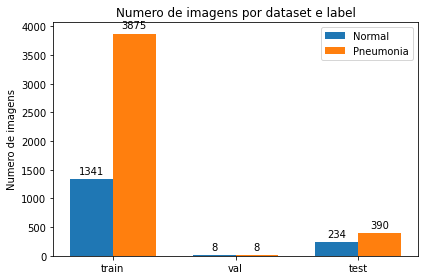

In [1]:
from casfml.data_loader.pneumonia_kaggle import PneumoniaKaggleLoader
from casfml.utils.json_hyperparameters import Params
hparams = Params('data/configuration_files/cls_params.json')

pneumoniaKaggle = PneumoniaKaggleLoader(hparams)
pneumoniaKaggle.plot_original_data_distribution()


Como pode-se observar na figura anterior, existe um desbalanceamento de classes para os tipos de etiqueta Normal/Pneumonia, sendo predominante o tipo de imagens classificadas como PNEUMONIA. Por outro lado o dataset definido como validation apresenta poucas imagens pelo qual não será usado no processo de treinamento. 

## Visualização de amostras
A seguir exemplos de imagens para os casos de raio-x normal e com pneumonia

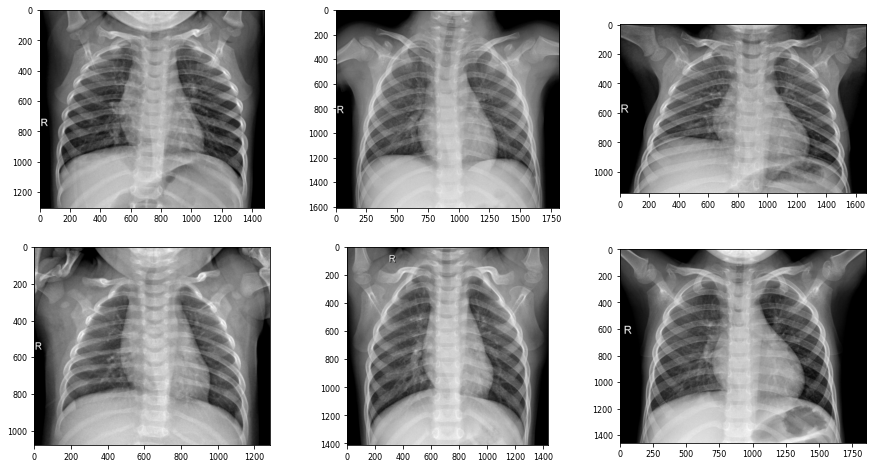

In [2]:
pneumoniaKaggle.show_samples('normal')

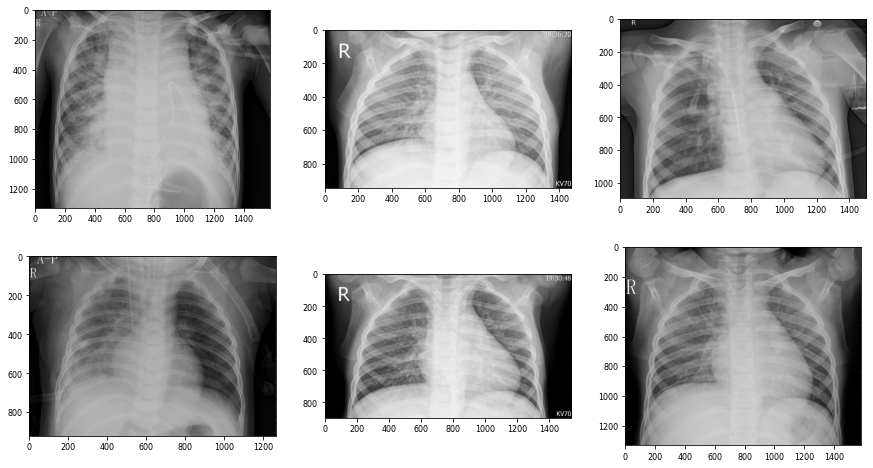

In [3]:
pneumoniaKaggle.show_samples('pneumonia')

## Processamento de dados

Devido a que será realizado um treinamento de modelos baseados em redes neurais profundas, foi escolhido uma abordagem de divisão holdout de dataset em três conjuntos fixos: treinamento, validação e test. Para facilitar o processamento dos dados será utilizada a classe `PneumoniaKaggleLoader`, responsável pela re-geração do dataset de treinamento/validação. Através da função  `create_split_training_with_balanced_validation_data` o dataset original de treinamento será redristibuido em novos conjuntos mais apropiados para o processo de treinamento. O conjunto de dados de treinamento será o utilizado pelo processo de otimização como informação para à obtenção dos pesos da rede neural que minimizem os erros de predição (e a função de perda). Já o conjunto de validação é o conjunto de dados utilizado para realizar o ajuste dos hyperparâmetros e conseguir o melhor desempenho possivel. Este conjunto foi balanceado em relação às classes para permitir uma avaliação apropriada do problema de classifação binaria. Embora o dataset de treinamento apresente desbalanceamento de classes, isto será mitigado usando estratégias de alocação pesos no calculo da função de perda no processo de treinamento. 

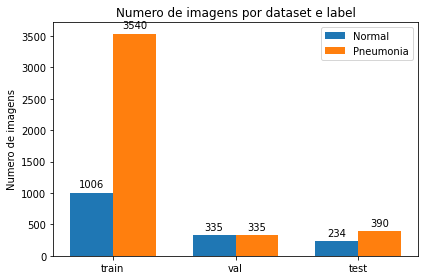

In [2]:
pneumoniaKaggle.create_split_training_with_balanced_validation_data(normal_percentage_data_from_training=0.25)
pneumoniaKaggle.plot_current_training_data_distribution()

Adicionalemente a classe `PneumoniaKaggleLoader` é a responsável de proporcionar `Data generators` para alimentar o processo de treinamento das redes neurais. Estes generators fornecem de batches de informação de forma on-line para facilitar o carregamento/transferencia da informação do disco/memoria RAM/memoria GPU. Por outro lado, os generators fornecem a possibilidade de aplicação de estrategias de "data augmentation" durante o processo de treinamento. Isto refere-se à aplicação de transformações geometricas sobre as imagens com o objetivo de enriquecer a variabilidade nos dados de treinamento aplicados.<br>
Obs. A técnica de data augmentation é aplicada apenas aos dados do conjunto de treinamento.

In [3]:
pneumoniaKaggle.create_data_generators()

Found 4546 validated image filenames belonging to 2 classes.
Found 670 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Processo de treinamento e validação

Neste projeto foram utilizados técnicas de aprendizado de máquina baseadas em redes neurais profundas. O modelo recebe como entrada todos os pixels da imagem normalizados entre 0-1. Os modelos realizarão o processamento da imagem extraindo os features de forma automática através de camadas convolucionais e finalmente realizando a classificação binaria nas camadas densas finais. A saída do modelo é uma função sigmoide tomando valores entre 0-1. Como valor threshold de desição, foi utilizado o valor 0.5. Desta forma, quando output > 0.5 a saída da rede será interpretada como presença de pneumonia.

## Arquivo de configuração
Para facilitar a configuração do processo de treinamento e ajuste de hiperparâmetros foi fornecido um arquivo de configuração JSON localizado em `data/config_files/cls_params.json`

```yaml
{
    "classes": ["normal", "pneumonia"],
    "n_classes":1,
    "model": "resnet18",
    "optimizer": "Adam",
    "loss":"binary_crossentropy",
    "batch_size": 128,
    "num_epochs": 40,
    "learning_rate": 0.001,
  
    "image_height": 128,
    "image_width": 128,
    "channels": 1,
  
    "apply_data_augmentation": false,
    "data_augmentation": {
        "rotation_range": 20,
        "width_shift_range": 0.2,
        "height_shift_range": 0.2,
        "shear_range": 0.2,
        "zoom_range": 0.1,
        "horizontal_flip": true,
        "vertical_flip": false,
        "fill_mode" : "constant"
      },

    "evaluate_validation_metrics":true,
    "evaluate_test_metrics":false,

    "save_model_results": true,
    "save_prefix":""

}
```

## Criação de modelos e loop de treinamento

As arquiteturas de rede neural e o processo de treinamento será apoiado com o uso da biblioteca `tensorflow`. Os métodos de criação, compilação, treinamento, avaliação e persistencia de resultados foram encapsulados nas classes `ModelTrainer` e `ModelManager`. Será possível obervar durante a execução do processo de treinamento a evolução na função de perda e na acuracia para cada episódio de treinamento gerando as chamadas "curvas de aprendizado". A avaliação destas curvas permitem determinar se ocorre "overfitting" ou "underfitting" para o modelo em processo de treinamento.

Para criação das arquiteturas de rede neural, a classe `ModelManager` integra funções das bibliotecas [efficientnet](https://github.com/qubvel/efficientnet) e [classification models](https://github.com/qubvel/classification_models). Com isto poderão ser diretamente criados varias arquiteturas do estado da arte modificando o campo model no arquivo de configuração. Dentre alguns dos modelos suportados se encontram:
- resnet18, resnet34, densenet169, mobilenet.
- EfficientNetB0, ..., EfficientNetB7
Para mais informações recomenda-se observar os modelos suportados pelas bibliotecas.

Adicionamente, a classe `ModelManager` suporta a criação de modelos customizados via `tensorflow.keras`. Como exemplo, integrou-se um modelo sequencial customizado que mostrou bons resultados nas métricas de classificação e tempo de processamento. Para utilizar o modelo sequencial deve se utilizar o nome `custom_model` no campo model de arquivo de configuração.

In [4]:
from casfml.models.model_trainer import ModelTrainer
trainer = ModelTrainer(hparams)

Obs --> O processo de treinamento, dependendo da complexidade da arquitetura e tamanho do batch_size (a depender da memoria GPU disponivel) utilizado pode levar entre 40 e 120 minutos quando executado em um ambiente com GPU.

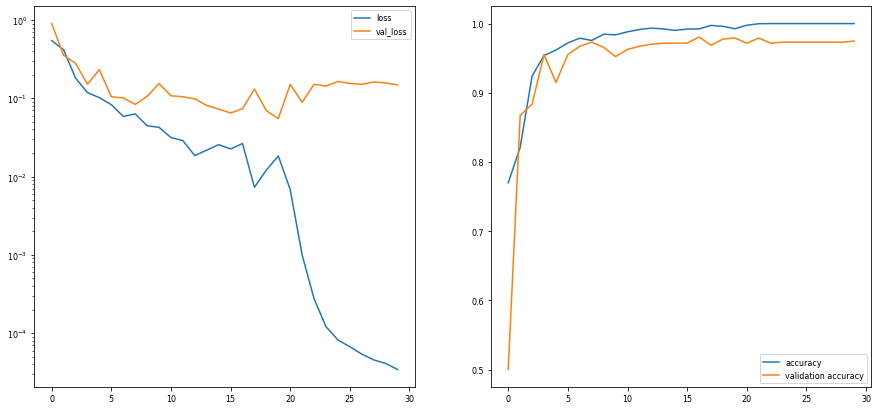

72/72 [==============================] - 31s 429ms/step - loss: 3.3858e-05 - accuracy: 1.0000 - val_loss: 0.1484 - val_accuracy: 0.9746


In [9]:
trainer.train(pneumoniaKaggle.train_generator,pneumoniaKaggle.val_generator,show_learning_curves=True)

# Geração de Reportes sobre o conjunto de validação

Na finalização do processo de treinamento, serão computadas as métricas de avaliação no dataset de validação. Com isto será possível fazer ajustes nos hyperparâmetros de treinamento até obter os resultados desejados. As metricas computadas são as seguintes:
- Acurácia
- F1
- Precisão
- Recal
- Curvas de aprendizado
- Matriz de confusão
- Curva ROC

## Avaliação de modelos e persistencia de resultados

A execução de treinamento gera e armazena automaticamente resultados para cada experimento executado refentes ao historico de treinamento, métricas de avaliação e melhor modelo na validação (formato h5) na pasta `data/results/`. Cada execução terá então como resultado a seguinte estrutura. 

```bash
└── data
    └── results
        └── chest_xray
            ├── custom_model_2022_0120_1633
            │   ├── history_results
            │   ├── metrics_evaluation
            │   ├── trained_model                    
```

In [ ]:
trainer.test_model(generator=pneumoniaKaggle.val_generator,dataset='validation')

## Comparação entre experimentos

In [1]:
from casfml.models.trained_reports import TrainedReports
trainedReports = TrainedReports()

Quando realizado o processo de treinamento de varios modelos de classificação, os resultados são armazenados em disco para futuras comparações. Com este fim a classe classe `TrainedReports` é a responsável de realizar ditas comparações entre as execuções. <br>
Para selecionar candidatos de comparação, deverá se fornecer uma lista com os nomes das pastas geradas como o resultado do treinamento. A seguir alguns exemplos:

In [2]:
experiment_list = ['custom_model_2022_0120_2158',
                    'EfficientNetB0_2022_0121_1107',
                    'densenet169_2022_0121_0942']

### Curvas de aprendizado
Esta função permite comparar o processo de treinamento para avaliação de ocorrencia de overfitting, underfitting nos conjuntos de treino e validação. As métricas aceitas pela funcão compare_learning_curves são: "loss" e "accuracy"

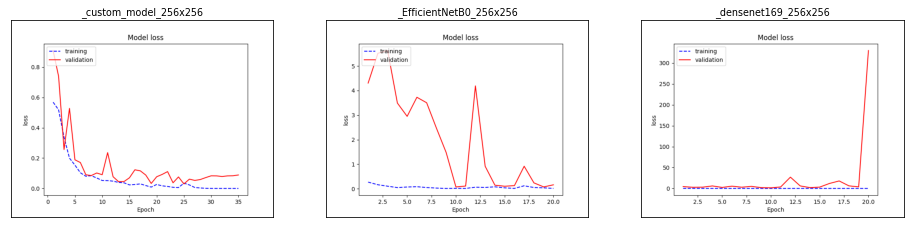

In [13]:
trainedReports.compare_learning_curves(experiment_list,metric='loss')

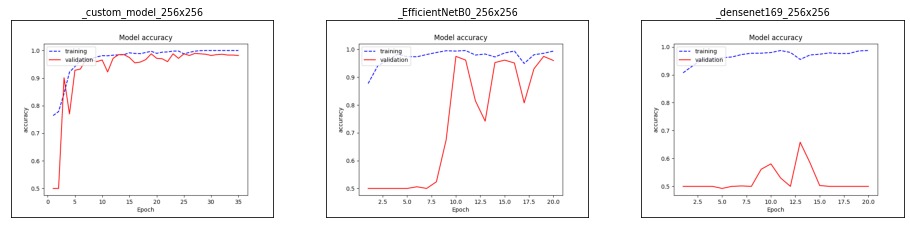

In [14]:
trainedReports.compare_learning_curves(experiment_list,metric='accuracy')

Dos resultados das curvas de aprendizado observa-se como os modelos EfficientNetB0 e Densenet tiveram uma maior dificuldade de generalização sobre o conjunto de validação no processo de aprendizado

### Matrices de confusão


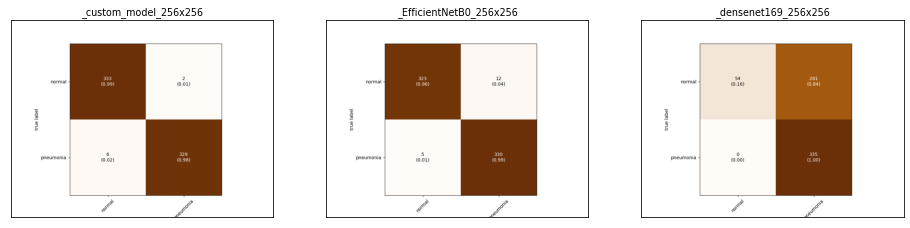

In [15]:
trainedReports.compare_confusion_matrix(experiment_list)

### Comparação de metricas de classificação
Na comparação de métricas de classificação será usado o arquivo que contem as predições de modelo para cada imagem. Desta forma usando as funções do sklearn será realizada a comparação para cada modelo da saída da rede e etiqueta. A função "compare metrics" será a responsável pela geração da tabela resumindo os resultados obtivos pelos modelos no conjunto de validação.  

In [3]:
trainedReports.compare_metrics(experiment_list)

       experiment_name  accuracy  precision   recall       f1
  custom_model_256x256  0.988060   0.993958 0.982090 0.987988
EfficientNetB0_256x256  0.974627   0.964912 0.985075 0.974889
   densenet169_256x256  0.580597   0.543831 1.000000 0.704522


# Verificação de desempenho sobre o conjunto de teste

Uma vez escolhidos os hyperparâmetros que geram os melhores resultados (ou a implementação de técnicas de model ensembling, entre outros) é necessario verificar que a abordagem desenvolvida funciona corretamente e é capaz de generalizar sobre dados nunca vistos (train/validation). 

In [5]:
experiment_to_test = 'custom_model_2022_0120_2158'
hparams_to_test = Params(f'data/results/{experiment_to_test}/trained_model/trained_params.json')

In [6]:
trainer_to_test = ModelTrainer(hparams_to_test)
trainer_to_test.load_trained_model(experiment_name=experiment_to_test)

loading best trained model

======= Metrics: test - experiment: custom_model_2022_0120_2158  =======

test Accuracy: 0.8141025641025641
test Precision: 0.7807377049180327
test Recall: 0.9769230769230769
test F1: 0.8678815489749431

======= Precision and Recall: test  =======

              precision    recall  f1-score   support

      normal      0.934     0.543     0.686       234
   pneumonia      0.781     0.977     0.868       390

    accuracy                          0.814       624
   macro avg      0.857     0.760     0.777       624
weighted avg      0.838     0.814     0.800       624


======= Confusion Matrix: test  =======

Confusion Matrix saved [mlxtend library]:
data/results\custom_model_2022_0120_2158\metrics_evaluation\test-cm.png


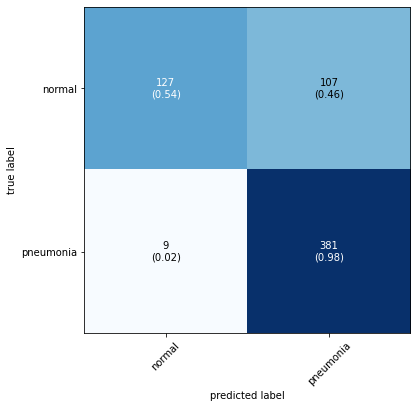

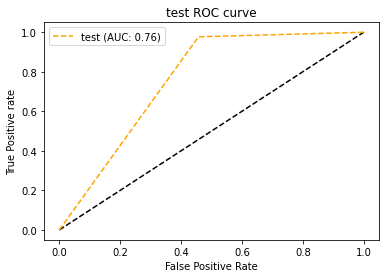

In [7]:
trainer_to_test.test_model(generator=pneumoniaKaggle.test_generator,dataset='test')

# Conclusão do treinamento

Embora as métricas de desempenho estejam adequadas no conjunto de validação, o modelo não apresenta um desempenho similar no conjunto de teste. Este comportamento pode estar relacionado a que os dados de validação e teste tenham diferenças importantes o que resultaria em um processo de ajuste de hiperparâmetros pouco eficiente. No entanto, levando em consideração que não foram utilizados técnicas de transfer learning, e a disponibilidade de poucos dados, observou-se um desempenho ponderado acima do 80% para as métricas de classificação no conjunto de teste. <br>
Por outro lado, o conjunto de teste apresenta um desbalanceamento que afeta diretamente a avaliação da clase NORMAL.

- Accuracy = 0.81
- weighted avg Precision = 0.838     
- weighted avg Recall = 0.814 
- weighted avg f1 = 0.800

## Resumo do processo de treinamento - diagrama de sequência
![plot](./data/readme_images/train_sequence_diagram_pneumoniaKaggle_casfranco.png)